In [1]:
using SeisMain, SeisProcessing, SeisPlot, PyPlot

# Explore application of the parabolic Radon transform on a real marine CMP gather

In [2]:
# 1- Download data set from web site (1 NMO-corrected CMP gather from the GOM)

download("http://seismic.physics.ualberta.ca/data/gom_cdp_nmo.su",
         "gom_cdp_nmo.su")

# 2- Convert SU to internal SeismicJulia format

SegyToSeis("gom_cdp_nmo.su", "gom_cdp_nmo.seis", format="su", input_type="ieee",
           swap_bytes=true)

# 3- Read data d and trace headers h

d, h = SeisRead("gom_cdp_nmo.seis")
i1 = 801; i2 = 1201
d = d[i1:i2, :]       # Use subset of the data
imute = findall(x->x==0,d)  # Extract indexes of muted data
offset = SeisMain.ExtractHeader(h, "h")
offset = offset*0.3048  # SI units 
href = maximum(abs.(offset))
nt = size(d, 1)
dt = h[1].d1;

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  650k  100  650k    0     0   996k      0 --:--:-- --:--:-- --:--:--  996k


number of traces: 92
number of samples per trace: 1751


0.004f0

In [5]:
# 4- Model data in the Radom domain via inersion with parabolic Radon transform
p  = collect(range(-0.3; stop=0.9,length=200))
param = Dict(:order=>"parab", :dt=>dt, :p=>p, :h=>offset, :href=>href,
             :flow=>0.0, :fhigh=>125.0)
m = SeisRadonFreqInv(d; mu=0.01, param...)

# 5- Filter primaries and keep multiples in Radon gather
mf = copy(m)
pcut = 0.1 
icut = findall(p .< pcut)
mf[:, icut] .= 0

# 6- Forward model multiples from Radon panel 
d_mult = SeisRadonFreqFor(mf, nt; param...)
   
# 7- Compute primaries = input data - modelled multiples
d_prim = d - d_mult
d_prim[imute] .= 0;

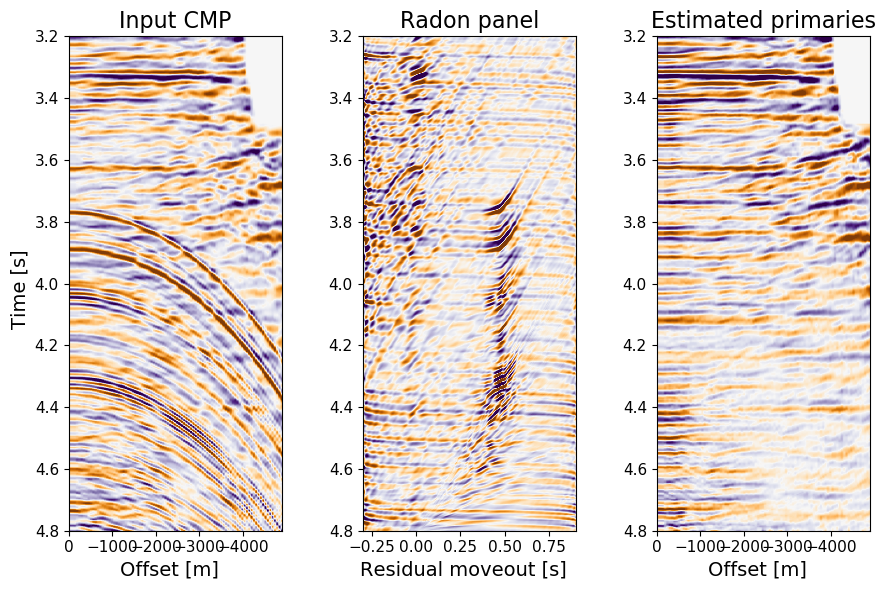

In [6]:
# 8- Plot input data, Radon panel, and estimated primaries

figure(1, figsize=(9,6));

t1 = (i1-1)*dt

subplot(131)
SeisPlotTX(d, title="Input CMP", xlabel="Offset [m]", ylabel="Time [s]",
         cmap="PuOr", ox=offset[1], dx=offset[2]-offset[1], oy=t1, dy=dt,
         fignum=1)

subplot(132)
SeisPlotTX(m[1:nt, :], title="Radon panel", xlabel="Residual moveout [s]",
         cmap="PuOr", ox=p[1], dx=p[2]-p[1], oy=t1, dy=dt, fignum=1)

subplot(133)
SeisPlotTX(d_prim, title="Estimated primaries", xlabel="Offset [m]", cmap="PuOr", 
         ox=offset[1], dx=offset[2]-offset[1], oy=t1, dy=dt, fignum=1)

tight_layout()